In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from geopandas.tools import sjoin
import seaborn as sns
from shapely.geometry import Point
from shapely.ops import polygonize
from shapely.geometry import MultiLineString
from shapely.geometry import Polygon, Point
from shapely import affinity
import contextily as ctx
import libpysal as ps
import pointpats.quadrat_statistics as qs
from pointpats import PointPattern, as_window
from pointpats import PoissonPointProcess as csr
from rtree import index
from collections import Counter
import warnings
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) 

Huanan Seafood market data sourced from: 

"Data and code for: The Huanan Seafood Wholesale Market in Wuhan was the early epicenter of the COVID-19" https://zenodo.org/record/6908012

WHO 2021. WHO-convened Global Study of Origins of SARS-CoV-2 : China Part (14 January-10 February 2021). https://www.who.int/docs/default-source/coronaviruse/final-joint-report_origins-studies-6-april-201.pdf

Gao G, Liu W, Wong G, Wang J, Wang F, Li M. Surveillance of SARS-CoV-2 in the environment and animal samples of the Huanan Seafood Market. Res Sq. doi:10.21203/rs.3.rs-1370392/v1

In [18]:
DATA_PATH='/mnt/1TB_0/Data/GIS/Wuhan_Early_Cases/'

In [19]:
df_who = gpd.read_file(DATA_PATH+"geojson/huanan-market-internal_edit.geojson")

In [20]:
df_who.head()

,title,group,fill,label,marker-color,stroke,geometry
0,B17 (scale),Env-Pos,None,None,#cc1b15,None,POINT (114.25617 30.62013)
1,D32 (wagon surface),Env-Pos,None,None,#cc1b15,None,POINT (114.25665 30.62018)
2,F13 (wall surface),Env-Pos,None,None,#cc1b15,None,POINT (114.25664 30.61993)
3,"E48 (blood from ground surface, in front of door)",Env-Pos,None,None,#cc1b15,None,POINT (114.25774 30.62010)
4,E61 (ground surface),Env-Pos,None,None,#cc1b15,None,POINT (114.25755 30.61975)


In [21]:
df_who.group.unique()

array(['Env-Pos', 'StreetNumber', 'WildlifeVendor', 'UnknownMeat',
       'Env-Neg', 'HumanCase'], dtype=object)

In [22]:
df_who.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [43]:
df_map = gpd.read_file(DATA_PATH+"geojson/huanan-market-internal_lines.geojson")

In [44]:
#rot_origin=df_map.unary_union.centroid
#df_map = df_map.rotate(-15.2, origin=rot_origin)

In [45]:
### Overall Huanan seafood market map

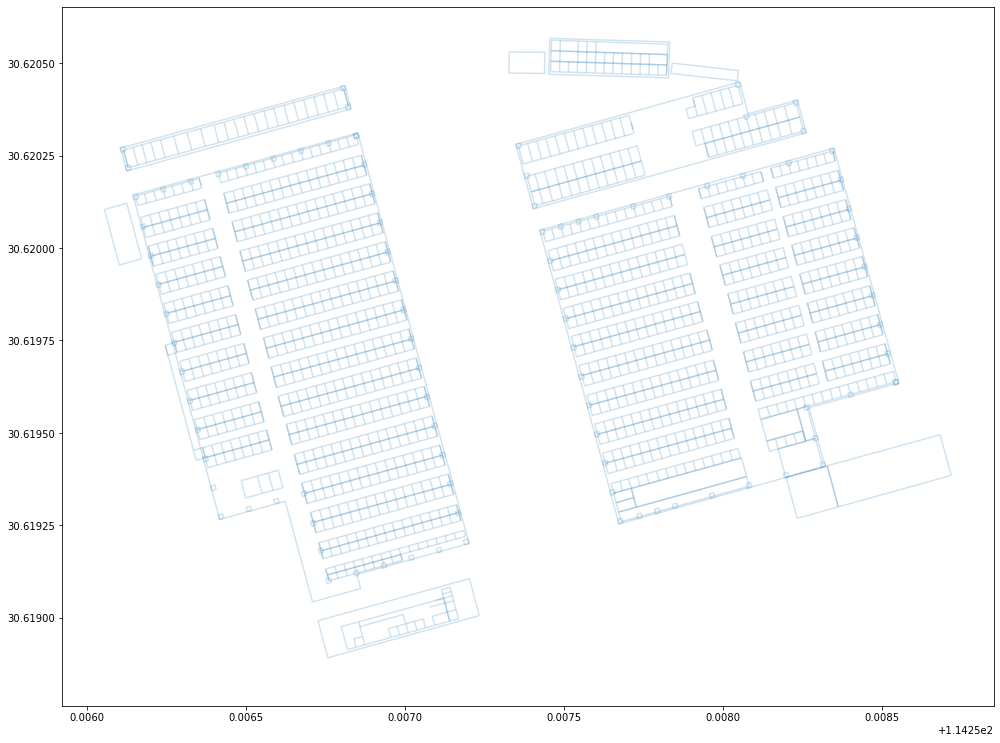

In [46]:
fig, ax = plt.subplots(figsize = (14,14))
df_map.plot(ax=ax, alpha = .2 )
plt.tight_layout()
plt.show()
#fig.savefig(DATA_PATH+"HSM_overview.png") 

In [26]:
#### Environmental sampling

In [27]:
env_sample_df=df_who[df_who["group"].isin(['Env-Pos','Env-Neg'])].copy(deep=True)
env_sample_df['id'] = env_sample_df.index

In [28]:
env_sample_df.head()

,title,group,fill,label,marker-color,stroke,geometry,id
0,B17 (scale),Env-Pos,None,None,#cc1b15,None,POINT (114.25617 30.62013),0
1,D32 (wagon surface),Env-Pos,None,None,#cc1b15,None,POINT (114.25665 30.62018),1
2,F13 (wall surface),Env-Pos,None,None,#cc1b15,None,POINT (114.25664 30.61993),2
3,"E48 (blood from ground surface, in front of door)",Env-Pos,None,None,#cc1b15,None,POINT (114.25774 30.62010),3
4,E61 (ground surface),Env-Pos,None,None,#cc1b15,None,POINT (114.25755 30.61975),4


In [29]:
x=env_sample_df['geometry'].apply(lambda p: p.x)
y=env_sample_df['geometry'].apply(lambda p: p.y)

env_sample_df['x']=x
env_sample_df['y']=y

In [30]:
env_sample_df.tail()

,title,group,fill,label,marker-color,stroke,geometry,id,x,y
182,,Env-Neg,None,None,#005e38,None,POINT (114.25789 30.61972),182,114.257890,30.619720
183,,Env-Neg,None,None,#005e38,None,POINT (114.25796 30.61957),183,114.257964,30.619568
184,,Env-Neg,None,None,#005e38,None,POINT (114.25813 30.61961),184,114.258127,30.619607
185,,Env-Neg,None,None,#005e38,None,POINT (114.25838 30.61967),185,114.258382,30.619668
186,,Env-Neg,None,None,#005e38,None,POINT (114.25634 30.61960),186,114.256335,30.619604


In [31]:
env_sample_df.x.min()

114.256172

In [33]:
print(f"Positive sample count: {len(df_who[df_who['group'].isin(['Env-Pos'])])}")
print(f"Negative sample count: {len(df_who[df_who['group'].isin(['Env-Neg'])])}")
print(f'Total environmental sample count: {len(env_sample_df)}')

Positive sample count: 35
Negative sample count: 111
Total environmental sample count: 146


#### All Environmental samples

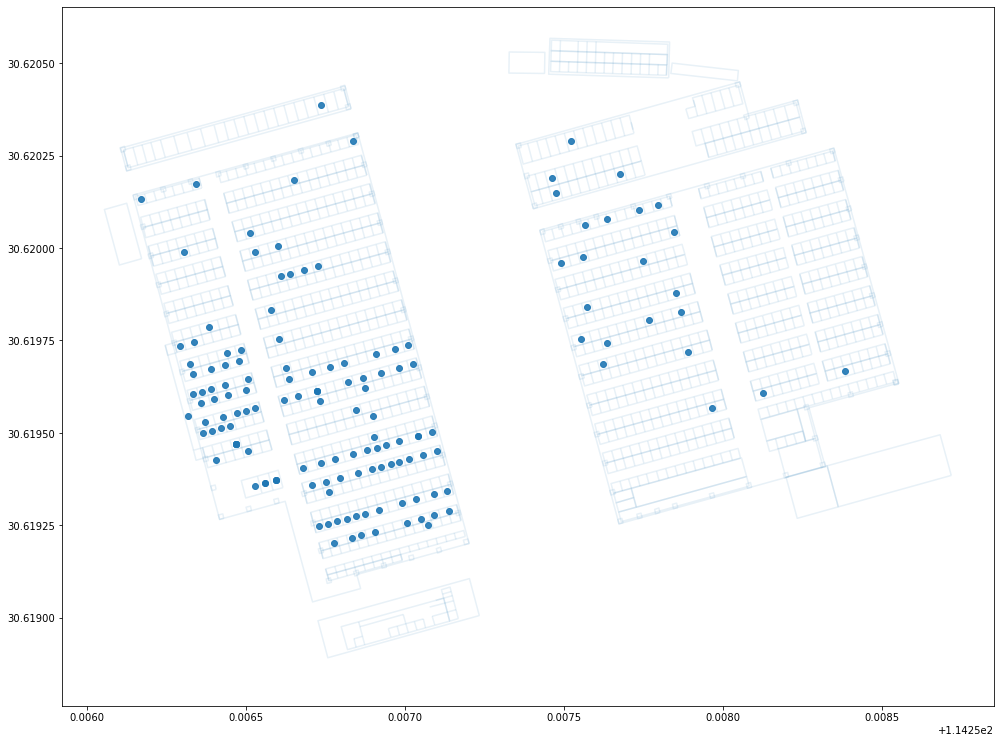

In [34]:
fig, ax = plt.subplots(figsize = (14,14))
env_sample_df.plot(ax=ax, alpha = .9 )
df_map.plot(ax=ax, alpha = .1 )
plt.tight_layout()
plt.show()
#plt.savefig(DATA_PATH+"HSM_env_all.png") 

In [47]:
df_WHO_wildlife = gpd.read_file(DATA_PATH+"geojson/WHO_wildlife.geojson")

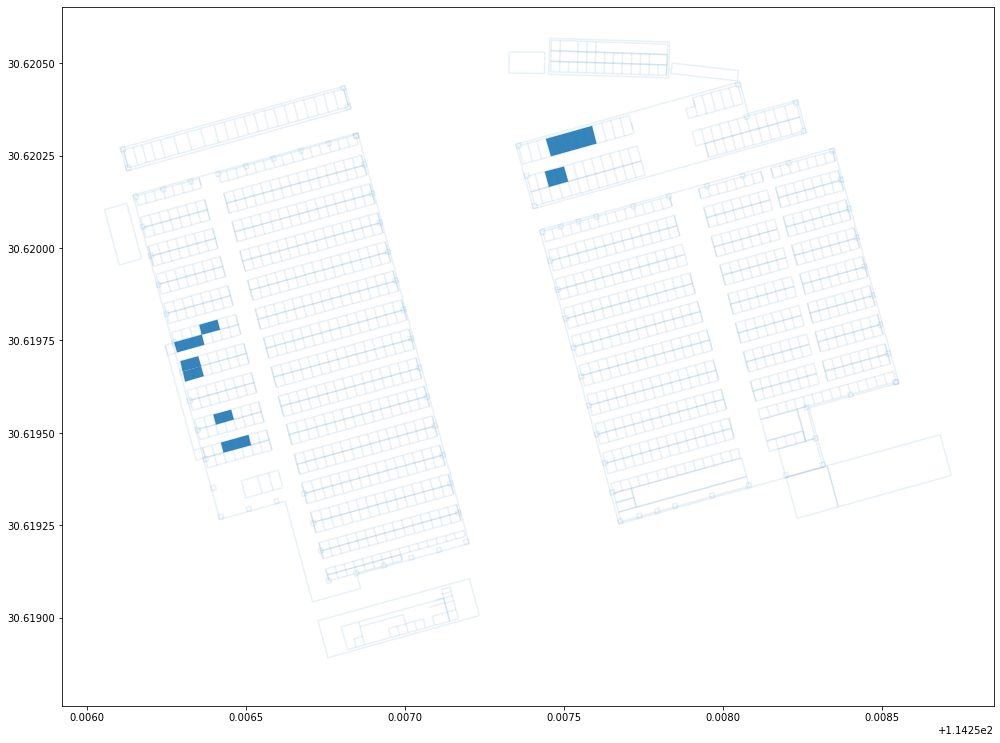

In [48]:
fig, ax = plt.subplots(figsize = (14,14))
df_WHO_wildlife.plot(ax=ax, alpha = .9 )
df_map.plot(ax=ax, alpha = .1 )
plt.tight_layout()
plt.show()

#### KDE map of all environmental samples

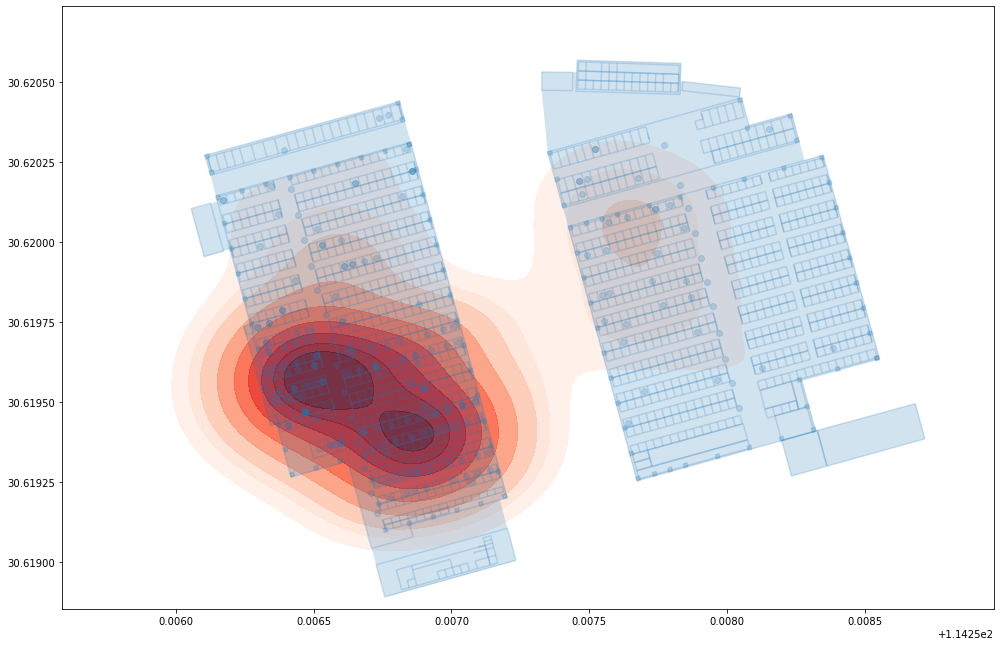

In [17]:
# Create thresholds
start = 0.1
n = 11
interval = 0.1
levels = np.arange(start, interval * n , interval)


# Create plot
f, ax = plt.subplots(ncols=1, figsize=(14, 14))
# Kernel Density Estimation
kde = sns.kdeplot(
    ax=ax,
    x=env_sample_df['geometry'].x,
    y= env_sample_df['geometry'].y,
    levels = levels,
    shade=True,
    cmap='Reds',
    alpha=0.9
)
# Add a basemap
#ctx.add_basemap(ax=ax,crs = env_sample_df.crs.to_string(), source=ctx.providers.CartoDB.Positron)
df_map.plot(ax=ax, alpha = .2 )
#ax.set_axis_off()
plt.tight_layout()

plt.show()
#plt.savefig(DATA_PATH+"HSM_env_KDE.png") 

#### Negative Environmental samples

#### Poitive and Negative Env samples

In [18]:
pos_sample_df=env_sample_df[env_sample_df["group"].isin(['Env-Pos'])].copy(deep=True)
neg_sample_df=env_sample_df[env_sample_df["group"].isin(['Env-Neg'])].copy(deep=True)

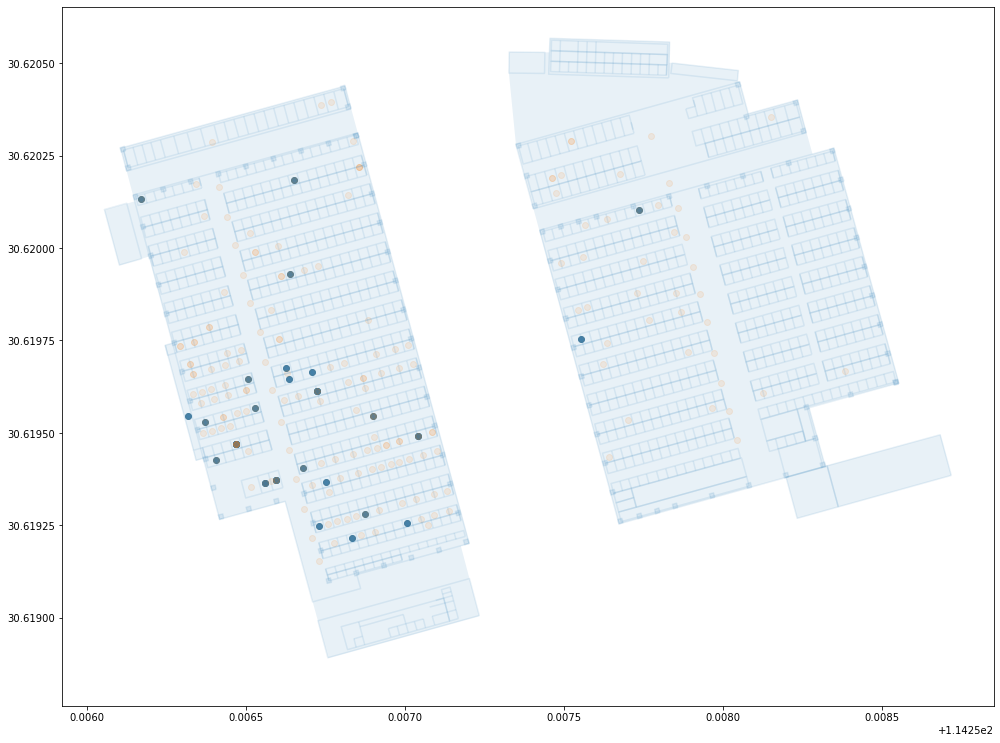

In [19]:
fig, ax = plt.subplots(figsize = (14,14))
pos_sample_df.plot(ax=ax, alpha = .9 )
df_map.plot(ax=ax, alpha = .1 )
plt.tight_layout()
plt.show()
#plt.savefig(DATA_PATH+"HSM_env_pos.png") 

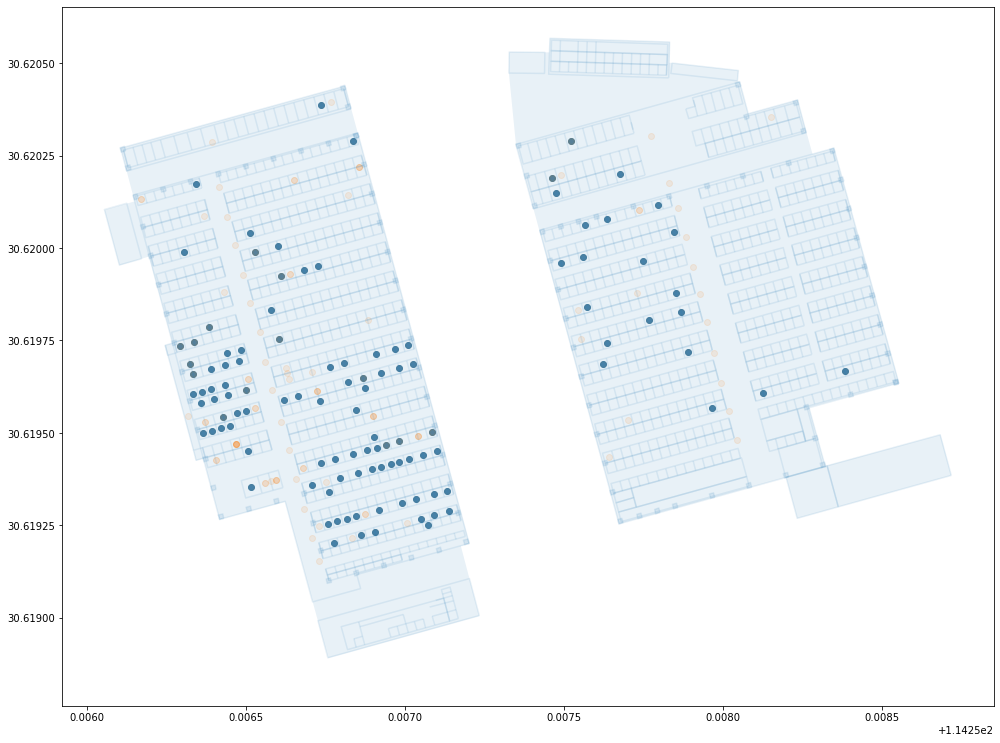

In [20]:
fig, ax = plt.subplots(figsize = (14,14))
neg_sample_df.plot(ax=ax, alpha = .9 )
df_map.plot(ax=ax, alpha = .1 )
plt.tight_layout()
plt.show()
#plt.savefig(DATA_PATH+"HSM_env_neg.png") 

#### Potitive KDE

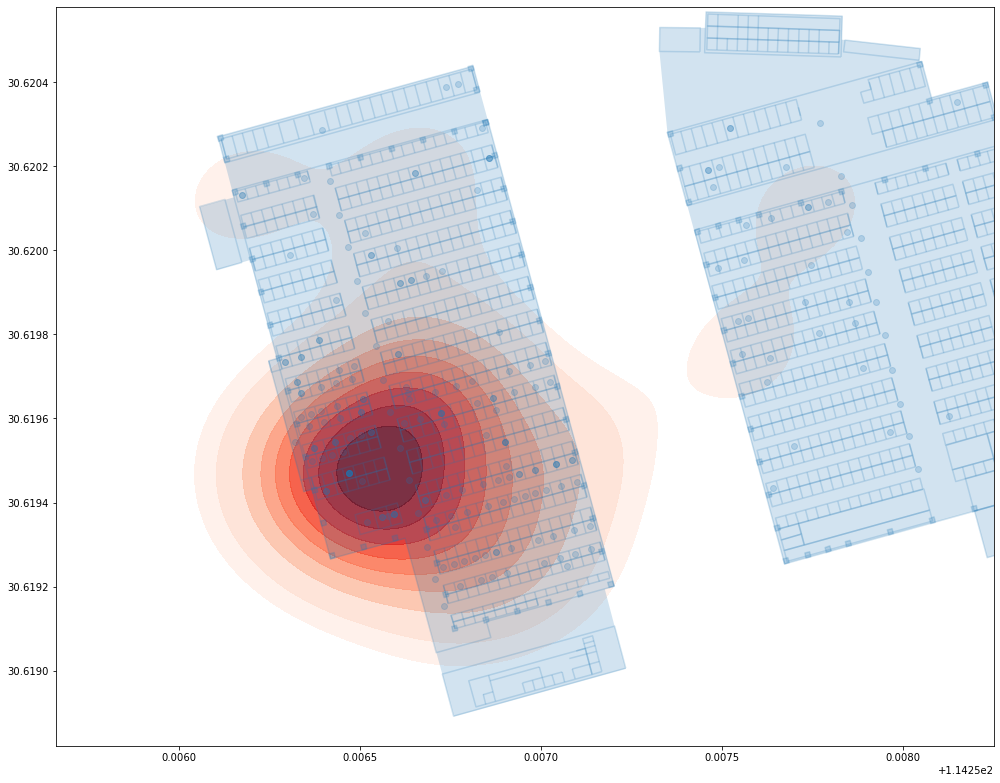

In [21]:
# Create thresholds
start = 0.1
n = 11
interval = 0.1
levels = np.arange(start, interval * n , interval)


# Create plot
f, ax = plt.subplots(ncols=1, figsize=(14, 14))
# Kernel Density Estimation
kde = sns.kdeplot(
    ax=ax,
    x=pos_sample_df['geometry'].x,
    y= pos_sample_df['geometry'].y,
    levels = levels,
    shade=True,
    cmap='Reds',
    alpha=0.9
)
# Add a basemap
#ctx.add_basemap(ax=ax,crs = env_sample_df.crs.to_string(), source=ctx.providers.CartoDB.Positron)
df_map.plot(ax=ax, alpha = .2 )
#ax.set_axis_off()
plt.tight_layout()

plt.show()
#plt.savefig(DATA_PATH+"HSM_pos_env_KDE.png") 

#### Negative KDE

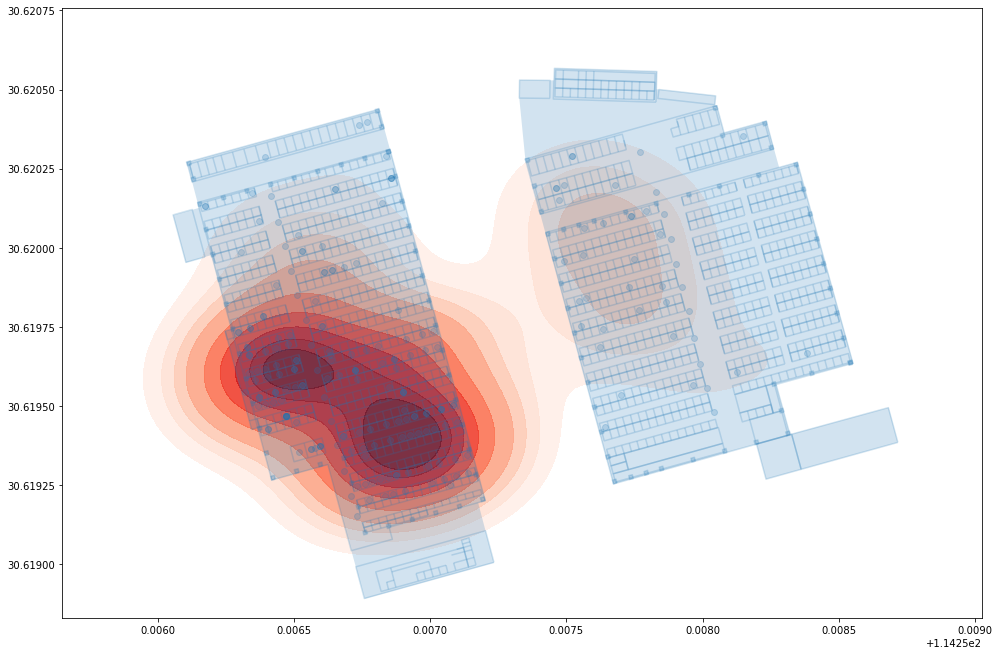

In [22]:
# Create thresholds
start = 0.1
n = 11
interval = 0.1
levels = np.arange(start, interval * n , interval)


# Create plot
f, ax = plt.subplots(ncols=1, figsize=(14, 14))
# Kernel Density Estimation
kde = sns.kdeplot(
    ax=ax,
    x=neg_sample_df['geometry'].x,
    y= neg_sample_df['geometry'].y,
    levels = levels,
    shade=True,
    cmap='Reds',
    alpha=0.9
)
# Add a basemap
#ctx.add_basemap(ax=ax,crs = env_sample_df.crs.to_string(), source=ctx.providers.CartoDB.Positron)
df_map.plot(ax=ax, alpha = .2 )
#ax.set_axis_off()
plt.tight_layout()

plt.show()
#plt.savefig(DATA_PATH+"HSM_neg_env_KDE.png") 

### Samples per grid area

In [23]:
#### Create a mesh grid

In [24]:
x_min=env_sample_df.x.min()
x_max=env_sample_df.x.max()

In [25]:
print(f'xmin: {x_min}, x_max:{x_max}')

xmin: 114.256172, x_max:114.258382


In [26]:
y_min=env_sample_df.y.min()
y_max=env_sample_df.y.max()
print(f'ymin: {y_min}, y_max:{y_max}')

ymin: 30.619202, y_max:30.620388


In [27]:
x_delta=x_max-x_min
y_delta=y_max-y_min

In [28]:
xcentroid = ((x_max-x_min)/2)+x_min
ycentroid = ((y_max-y_min)/2)+y_min

#### Re-run from here if want to change the gridding density

In [1347]:
#GRID_N=13
GRID_NX=12
GRID_NY=12
ROTATION=13.3
PADDING=2

In [1348]:
start = 0
xinterval = x_delta/GRID_NX
xedges = np.arange(start, xinterval * (GRID_NX+PADDING) , xinterval)
xedges=xedges+x_min
#not needed if useing rotated grid
#xedges = np.insert(xedges, 0, x_min-xinterval)
yinterval = y_delta/GRID_NY
yedges = np.arange(start, yinterval * (GRID_NY+PADDING) , yinterval)
yedges=yedges+y_min
#yedges = np.insert(yedges, 0, y_min-yinterval)

In [1349]:
hlines = [((x1, yi), (x2, yi)) for x1, x2 in zip(xedges[:-1], xedges[1:]) for yi in yedges]
vlines = [((xi, y1), (xi, y2)) for y1, y2 in zip(yedges[:-1], yedges[1:]) for xi in xedges]

polys = list(polygonize(MultiLineString(hlines + vlines)))
_id = [i for i in range(len(polys))]
grid = gpd.GeoDataFrame({"id":_id,"geometry":polys})
grid=grid.set_crs(df_map.crs)

In [1350]:
grid.head()

,id,geometry
0,0,"POLYGON ((114.25636 30.61920, 114.25617 30.619..."
1,1,"POLYGON ((114.25636 30.61930, 114.25617 30.619..."
2,2,"POLYGON ((114.25636 30.61940, 114.25617 30.619..."
3,3,"POLYGON ((114.25636 30.61950, 114.25617 30.619..."
4,4,"POLYGON ((114.25636 30.61960, 114.25617 30.619..."


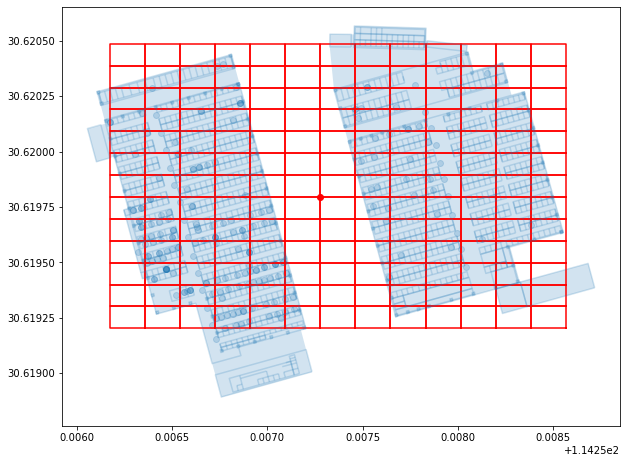

In [1351]:
plot_grid(polys, rotate=0)

#### create rotated grid

In [1352]:
grid_rot=grid.copy(deep=True)
grid_rot['geom_rot']=[0]*len(grid)

In [1353]:
for i,p in enumerate(polys):
    poly_rot = affinity.rotate(p.exterior, ROTATION, (xcentroid, ycentroid))
    grid_rot.loc[i, 'geom_rot'] = poly_rot

In [1354]:
grid_rot.drop('geometry', axis=1, inplace=True)

In [1355]:
def convert_linearing_poly(c):
    return Polygon(c)

grid_rot['geometry'] = grid_rot.apply(lambda row: convert_linearing_poly(row['geom_rot']), axis=1)

/tmp/ipykernel_317585/2003542553.py:4: FutureWarning: Setting geometries to a GeoDataFrame without a geometry column will currently preserve the CRS, if present. This is deprecated, and in the future the CRS will be lost in this case. You can use set_crs(..) on the result to set the CRS manually.
  grid_rot['geometry'] = grid_rot.apply(lambda row: convert_linearing_poly(row['geom_rot']), axis=1)


In [1356]:
grid_rot.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [1357]:
grid_rot.drop('geom_rot', axis=1, inplace=True)
grid_rot.head()

,id,geometry
0,0,"POLYGON ((114.25652 30.61901, 114.25634 30.618..."
1,1,"POLYGON ((114.25649 30.61910, 114.25632 30.619..."
2,2,"POLYGON ((114.25647 30.61920, 114.25629 30.619..."
3,3,"POLYGON ((114.25645 30.61929, 114.25627 30.619..."
4,4,"POLYGON ((114.25643 30.61939, 114.25625 30.619..."


In [1358]:
polys_rot=grid_rot.geometry.tolist()

In [1359]:
def plot_grid(polys, rotate=0):
    #rotation of 13.3 lines up grid with stall lanes
    fig, ax = plt.subplots(figsize = (10,10))
    for p in polys:
        if rotate!=0:
            line_rot_11 = affinity.rotate(p.exterior, rotate, (xcentroid, ycentroid))
            x, y = line_rot_11.xy
        else:
            x, y = p.exterior.xy
        plt.plot(x, y, c="red")
    df_map.plot(ax=ax, alpha = .2 )
    plt.plot(xcentroid,ycentroid,'ro') 
    plt.show()

In [1360]:
ROTATED=False

#### replace grid with rotated grid

Comment out this cell below to use unrotated grid

In [1361]:
grid_backup=grid.copy(deep=True)
grid=grid_rot
ROTATED=True

#### Points in polygons

see https://gis.stackexchange.com/questions/358735/how-to-obtain-mean-maximum-and-mininum-of-all-points-located-within-polygons-u

In [1362]:
points_polys = sjoin(env_sample_df, grid, how='left')

In [1363]:
#id_left are the point ids, ensure there are no duplicates
points_polys = points_polys.drop_duplicates(subset=['id_left'])

In [1364]:
#assert len(points_polys)==len(env_sample_df)

In [1365]:
points_polys.head()

,title,group,fill,label,marker-color,stroke,geometry,id_left,x,y,index_right,id_right
0,B17 (scale),Env-Pos,None,None,#cc1b15,None,POINT (114.25617 30.62013),0,114.256172,30.620132,11.0,11.0
1,D32 (wagon surface),Env-Pos,None,None,#cc1b15,None,POINT (114.25665 30.62018),1,114.256651,30.620185,50.0,50.0
2,F13 (wall surface),Env-Pos,None,None,#cc1b15,None,POINT (114.25664 30.61993),2,114.256640,30.619930,34.0,34.0
3,"E48 (blood from ground surface, in front of door)",Env-Pos,None,None,#cc1b15,None,POINT (114.25774 30.62010),3,114.257737,30.620102,111.0,111.0
4,E61 (ground surface),Env-Pos,None,None,#cc1b15,None,POINT (114.25755 30.61975),4,114.257555,30.619754,95.0,95.0


In [1366]:
#create environmental -ve and +ve sampling dataframes
points_polys_neg=points_polys[points_polys["group"].isin(['Env-Neg'])].copy(deep=True)
points_polys_pos=points_polys[points_polys["group"].isin(['Env-Pos'])].copy(deep=True)

In [1367]:
#id_right are the grid polygons
#points_polys_neg.groupby(['id_right']).size().reset_index(name='count')

#### R-tree

In [1368]:
# Populate R-tree index with bounds of polygons
rt_idx = index.Index()
grid_list=grid.geometry.tolist()
for pos, poly in enumerate(grid_list):
    rt_idx.insert(pos, poly.bounds)

In [1369]:
#see https://stackoverflow.com/questions/23871409/optimal-way-of-aggregating-geographic-points-with-python-shapely/24114565#24114565
def get_intersections(rt_idx,poly_df):
    pt_idxs=[]
    poly_idxs=[]
    non_intersecting_pts=[]
    for j in range(len(poly_df)):
        point = poly_df['geometry'].iloc[j]
        poly_idx = [i for i in rt_idx.intersection((point.coords[0]))
                    if point.within(grid_list[i])]
        if len(poly_idx)>0:
            pt_idxs.append(poly_df['id_left'].iloc[j])
            poly_idxs.append(poly_idx)
        else:
            non_intersecting_pts.append(poly_df['id_left'].iloc[j])
    poly_idxs=[item for sublist in poly_idxs for item in sublist]
    return pt_idxs,poly_idxs,non_intersecting_pts 

In [1370]:
neg_pt_idxs,neg_poly_idxs,neg_non_intersecting_pts =get_intersections(rt_idx,points_polys_neg)
pos_pt_idxs,pos_poly_idxs,pos_non_intersecting_pts =get_intersections(rt_idx,points_polys_pos)

In [1371]:
pos_non_intersecting_pts

[]

In [1372]:
neg_non_intersecting_pts

[1147]

In [1373]:
len(pos_pt_idxs)

35

In [1374]:
neg_counter = Counter(neg_poly_idxs) 
neg_poly_idx_counts=dict(neg_counter)
pos_counter = Counter(pos_poly_idxs) 
pos_poly_idx_counts=dict(pos_counter)

In [1375]:
#add counts into grid polygon dataframe

In [1376]:
grid['pos_counts'] = [0]*len(grid)
grid['neg_counts'] = [0]*len(grid)

In [1377]:
assert grid.index.tolist() == grid_rot.id.tolist()

In [1378]:
for k,v in neg_poly_idx_counts.items():
    grid.loc[k, 'neg_counts'] = v
    
for k,v in pos_poly_idx_counts.items():
    grid.loc[k, 'pos_counts'] = v

In [1379]:
pct_pos=grid['pos_counts'] / (grid['pos_counts']+grid['neg_counts'])*100

In [1380]:
grid['pct_pos']=pct_pos

In [1381]:
grid['pct_neg']=100-grid['pct_pos']
#grid=grid.fillna(0)

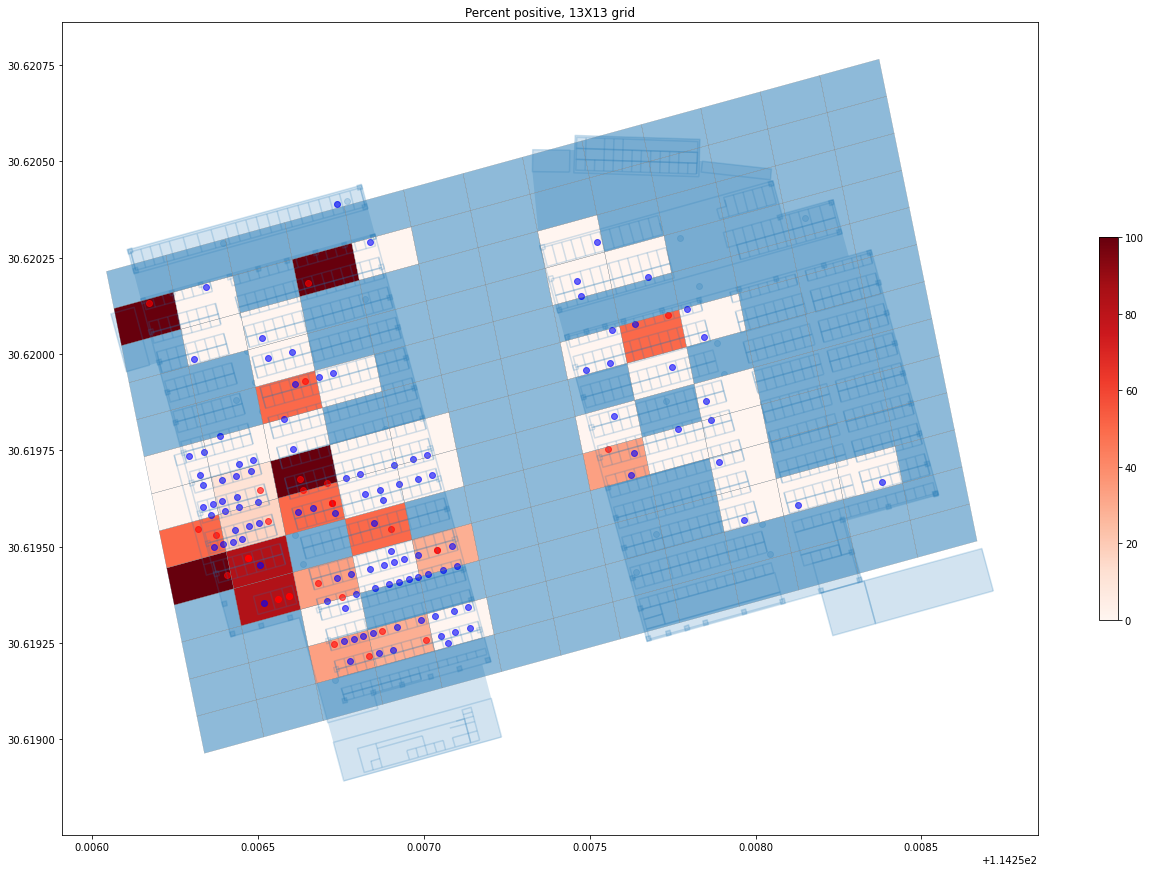

In [1382]:
fig, ax = plt.subplots(figsize = (18,18))
df_map.plot(ax=ax, alpha = .2 )

for p in polys_rot:
    x, y = p.exterior.xy
    plt.plot(x, y, c="grey", linewidth=0.2)
grid.plot(ax=ax, alpha=0.5)
grid.plot(column = 'pct_pos', ax=ax, cmap = 'Reds',
            legend = True, legend_kwds={'shrink': 0.3}, 
            markersize = 10)
ax.set_title(f'Percent positive, {GRID_NX+PADDING-1}X{GRID_NY+PADDING-1} grid')
neg_sample_df.plot(ax=ax, alpha = .6, c='b')
pos_sample_df.plot(ax=ax, alpha = .6, c='r')
plt.tight_layout()
plt.savefig(DATA_PATH+f"HSM_percent_positive_{GRID_NX+PADDING-1}X{GRID_NY+PADDING-1}_rot_{ROTATION}_rotated_{ROTATED}.png") 
plt.show()

In [ ]:
### Human cases

In [1386]:
market_map_df=df_map[df_map["group"].isin(['MarketMap'])].copy(deep=True)
boundary_df=df_map[df_map["group"].isin(['Boundary'])].copy(deep=True)

In [1397]:
#'StreetNumber', 

wildlife_vendor_df=df_map[df_map["group"].isin(['WildlifeVendor'])].copy(deep=True)
meat_map_df=df_map[df_map["group"].isin(['UnknownMeat'])].copy(deep=True)

In [1383]:
human_df=df_map[df_map["group"].isin(['HumanCase'])].copy(deep=True)

In [1385]:
human_df.head()

,title,group,fill,label,marker-color,stroke,geometry
1196,After,HumanCase,None,None,#fb6033,None,POINT (114.25643 30.61988)
1197,After,HumanCase,None,None,#fb6033,None,POINT (114.25658 30.61937)
1198,After,HumanCase,None,None,#fb6033,None,POINT (114.25650 30.61962)
1199,After,HumanCase,None,None,#fb6033,None,POINT (114.25617 30.62013)
1200,After,HumanCase,None,None,#fb6033,None,POINT (114.25639 30.62029)


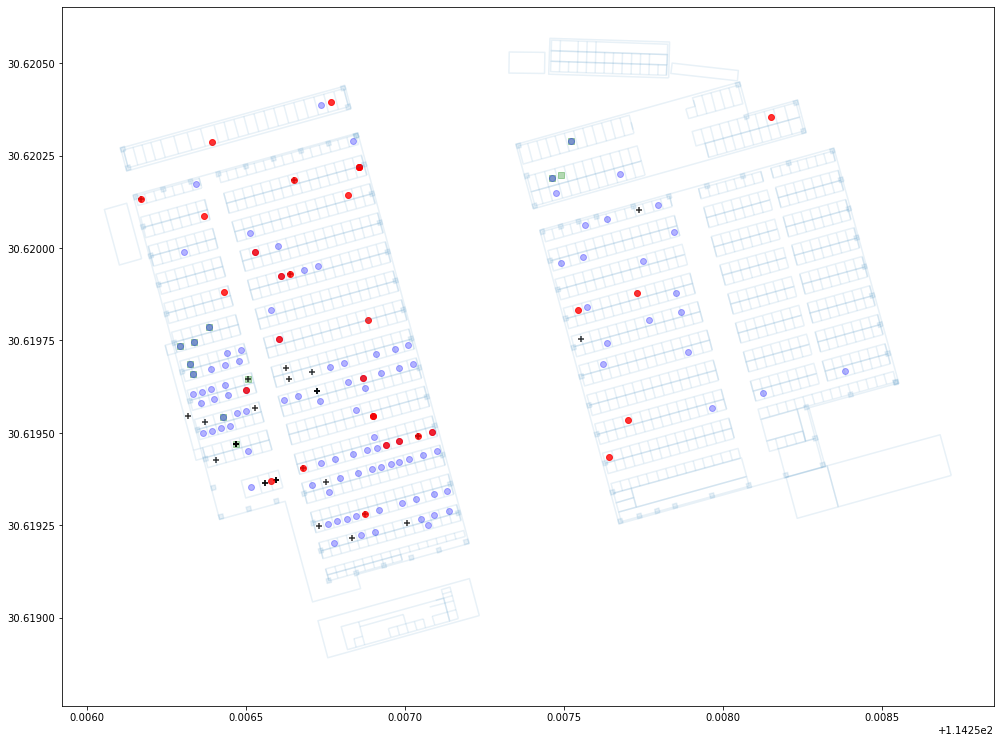

In [1403]:
fig, ax = plt.subplots(figsize = (14,14))
market_map_df.plot(ax=ax, alpha = .1 )
wildlife_vendor_df.plot(ax=ax, alpha = .3, c='g', marker='s')
neg_sample_df.plot(ax=ax, alpha = .3, c='b', marker='o' )
pos_sample_df.plot(ax=ax, alpha = .8, c='black', marker='+' )
human_df.plot(ax=ax, alpha = .8, c='r' )
#boundary_df.plot(ax=ax, alpha = .5 )
plt.tight_layout()
plt.savefig(DATA_PATH+f"HSM_wildlife_neg_ps_human_pts.png") 
#plt.show()

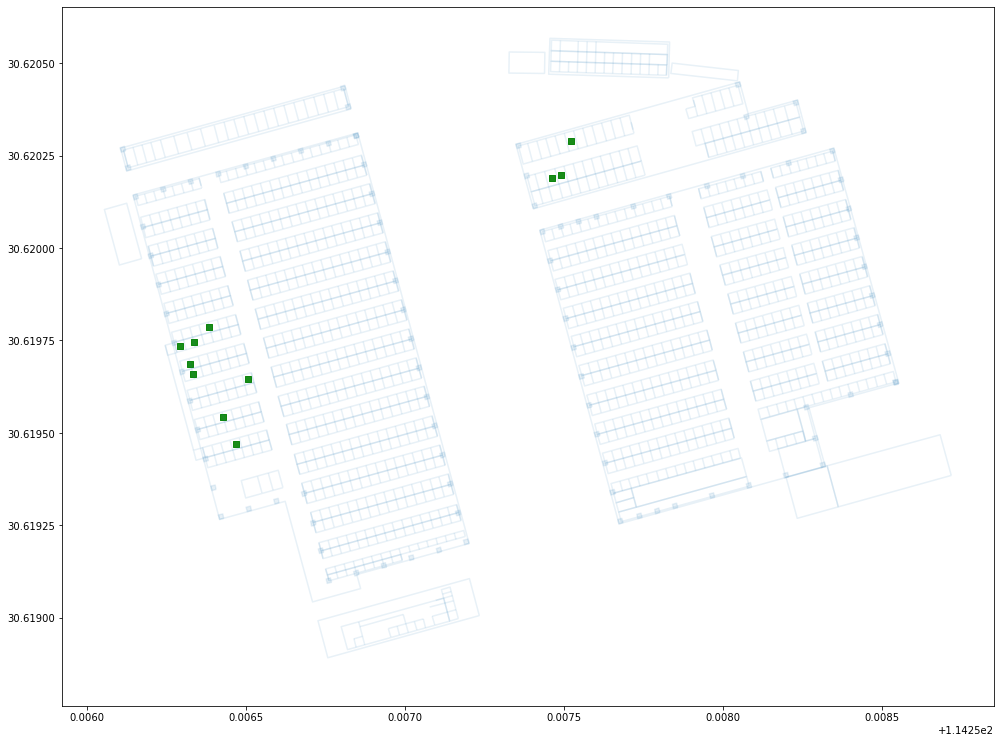

In [1401]:
fig, ax = plt.subplots(figsize = (14,14))
market_map_df.plot(ax=ax, alpha = .1 )
wildlife_vendor_df.plot(ax=ax, alpha = .9, c='g', marker='s')
#neg_sample_df.plot(ax=ax, alpha = .3, c='b', marker='o' )
#pos_sample_df.plot(ax=ax, alpha = .8, c='black', marker='+' )
#human_df.plot(ax=ax, c='r' )
#boundary_df.plot(ax=ax, alpha = .5 )
plt.tight_layout()
plt.show()

#### Pysal

For this Pysal code section, for the local market area we assume the geodetic coordinates approximate cartesian coordinates

In [254]:
xy = np.stack((points_polys.x.tolist(), points_polys.y.tolist()), axis=1)

In [256]:
pp_xy = PointPattern(xy)

In [257]:
pp_xy.summary()

Point Pattern
146 points
Bounding rectangle [(114.256172,30.619202), (114.258382,30.620388)]
Area of window: 2.621059999985409e-06
Intensity estimate for window: 55702654.651481755
            x          y
0  114.256172  30.620132
1  114.256651  30.620185
2  114.256640  30.619930
3  114.257737  30.620102
4  114.257555  30.619754


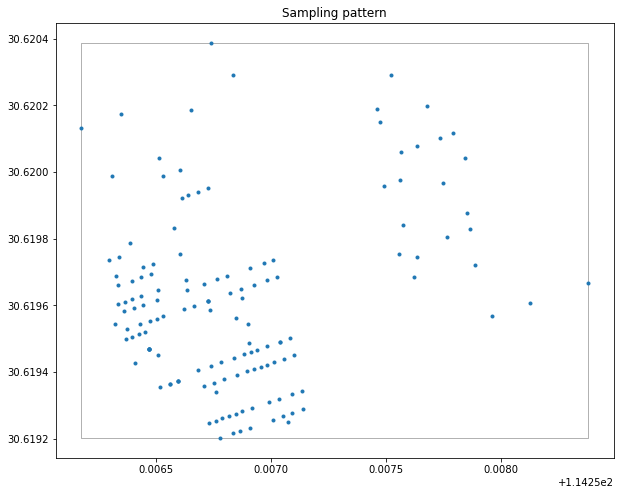

In [274]:
plt.rcParams["figure.figsize"] = (10,8)
pp_xy.plot(window= True, title= "Sampling pattern")

In [275]:
q_r = qs.QStatistic(pp_xy,shape= "rectangle",nx = 10, ny = 10)

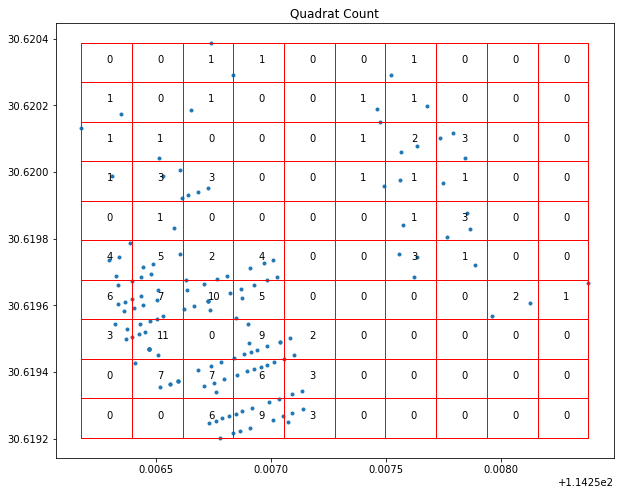

In [276]:
plt.rcParams["figure.figsize"] = (10,8)
q_r.plot()